# Strategic Location for Establishing an Asian Restaurant 

## Introduction / Business Problem

The success of establishing a new restaurant depends on several factors: demand, brand loyalty, quality of food, competition, and so on. In most cases, a restaurant's location plays an essential determinant for its success. Hence, it is advantageous and of utmost importance to determine the most strategic location for establishment in order to maximize business profits.

<h3>Business Problem:</h3> Client seeks to establish a franchised Asian restaurant in a Toronto neighborhood. Which neighborhood would appear to be the optimal and most strategic location for the business

A client seeks to establish a franchised Asian restaurant in a Toronto neighborhood. Which neighbourhood would appear to be the optimal and most strategic location for the business operations? 
The objective of this capstone project is to locate the optimal neighborhood for operation. Our foundation of reasoning would be based off of spending power, distribution of ethnic group, and competition, across each neighbourhood. We will mainly be utilizing the Foursquare API and the extensive geographical and census data from Toronto's Open Data Portal. 


## Data
The Foursquare API will be used to explore neighborhoods in Toronto, more specifically, we will be using the <i>explore</i> function to get the most common venue categories in each neighborhood.

Neighbourhood names, alongside their corresponding boroughs and postal codes, scraped from Wikipedia: (https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050)

The Toronto's census data for its social demographic characteristics will be distilled from Toronto's <i>Neighborhood Profile</i> (https://bit.ly/3airrOJ).

Geographical coordinates of each neighbourhood: (https://cocl.us/Geospatial_data)

### Import Data from census CSV files

In [1]:
import pandas as pd
import numpy as np

### Load data and store in respective dataframes

In [2]:
# load total population of each Toronto neighbourhood
pop_path = pd.read_csv('population.csv')
df_pop = pd.DataFrame(pop_path)
df_pop.drop(['Neighbourhood Id'], axis=1, inplace=True)

# load population of Southeast Asians in Toronto neighbourhoods
ethnic_path = pd.read_csv('ethnic.csv')
df_ethnic = pd.DataFrame(ethnic_path)
df_ethnic.drop(['Neighbourhood Id'], axis=1, inplace=True)
df_ethnic.rename(columns={'   Southeast Asian': 'Southeast Asian'}, inplace=True)

# load household income of each Toronto neighbourhood
income_path = pd.read_csv('income.csv')
df_income = pd.DataFrame(income_path)
df_income.drop(['Neighbourhood Id'], axis=1, inplace=True)

print("{}, {}, {}".format(df_ethnic.shape[1], df_pop.shape[1], df_income.shape[1]))

2, 2, 2


### Merge the three dataframes 

In [3]:
from functools import reduce
dfs = [df_pop, df_ethnic, df_income]
df_census = reduce(lambda left,right: pd.merge(left,right,on='Neighbourhood'), dfs)
df_census.rename(columns={'After-Tax Household Income': 'Household Income'}, inplace=True)
df_census

,Neighbourhood,Total Population,Southeast Asian,Household Income
0,West Humber-Clairville,33312.0,490.0,59703.0
1,Mount Olive-Silverstone-Jamestown,32954.0,590.0,46986.0
2,Thistletown-Beaumond Heights,10360.0,120.0,57522.0
3,Rexdale-Kipling,10529.0,170.0,51194.0
4,Elms-Old Rexdale,9456.0,370.0,49425.0
...,...,...,...,...
135,West Hill,27392.0,215.0,46803.0
136,Woburn,53485.0,315.0,47908.0
137,Eglinton East,22776.0,195.0,42790.0
138,Scarborough Village,16724.0,70.0,40181.0


### Merging geographical data

In [4]:
df_geo = pd.read_csv("https://cocl.us/Geospatial_data")
df_geo

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


In [5]:
df = pd.read_html('https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050')[0]

df = df[df.Borough!='Not assigned']
df = pd.merge(df, df_geo, left_on='Postcode', right_on='Postal Code').drop(['Postal Code', 'Postcode', 'Borough'], axis=1)
df = pd.merge(df, df_census, on='Neighbourhood', how='left').dropna(how='any', axis=0).reset_index(drop=True)
df.head()

,Neighbourhood,Latitude,Longitude,Total Population,Southeast Asian,Household Income
0,Victoria Village,43.725882,-79.315572,17510.0,95.0,43743.0
1,Rouge,43.806686,-79.194353,46496.0,295.0,72784.0
2,Malvern,43.806686,-79.194353,43794.0,200.0,53425.0
3,Highland Creek,43.784535,-79.160497,12494.0,85.0,87321.0
4,Flemingdon Park,43.725900,-79.340923,21933.0,230.0,43511.0


### Get the percentage of Southeast Asian in the total population

In [6]:
df['Percentage of Southeast Asian'] = df['Southeast Asian'] / df['Total Population'] * 100
df.drop(['Total Population', 'Southeast Asian'], axis=1, inplace=True)
df.head()

,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Southeast Asian
0,Victoria Village,43.725882,-79.315572,43743.0,0.542547
1,Rouge,43.806686,-79.194353,72784.0,0.634463
2,Malvern,43.806686,-79.194353,53425.0,0.456684
3,Highland Creek,43.784535,-79.160497,87321.0,0.680327
4,Flemingdon Park,43.725900,-79.340923,43511.0,1.048648


### Create a Folium map

In [7]:
# get location of Toronto using geopy
from geopy.geocoders import Nominatim
address = 'Toronto'
geolocator = Nominatim(user_agent='to_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print("The geographical coordinates of Toronto are {}, {}".format(latitude, longitude))

The geographical coordinates of Toronto are 43.6534817, -79.3839347


In [8]:
# Folium mapping
import folium
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighbourhood in zip(df['Latitude'], df['Longitude'], df['Neighbourhood']):
  label = '{}'.format(neighbourhood)
  label = folium.Popup(label)
  folium.CircleMarker(
      [lat,lng],
      radius=8,
      color='blue',
      popup=label,
      fill_color='#3186cc',
      fill_opacity=0.7,
      fill=True

  ).add_to(map_Toronto)

map_Toronto

### Explore the neighbourhood using the Foursquare API

In [12]:
#@title
# define Foursquare API credentials and version
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '' # Foursquare API version

### Get the top 100 venues that are in Toronto within a radius of 1500 meters

In [80]:
import requests
LIMIT = 100
radius = 1500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        lng,
        radius,
        LIMIT
    )

def getNearbyVenues(names, latitudes, longitudes, radius=1500):
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)

    #create the API request url
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT
        )

    # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']

    # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results
            ])
  
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood',
                           'Neighbourhood Latitude',
                           'Neighbourhood Longitude',
                           'Venue',
                           'Venue Latitude',
                           'Venue Longitude',
                           'Venue Category']

    return(nearby_venues)                         

In [81]:
# run the function above to each neighborhood and create a new dataframe called manhattan_venues
toronto_venues = getNearbyVenues(names=df['Neighbourhood'],
                                 latitudes=df['Latitude'],
                                 longitudes=df['Longitude'])

toronto_venues

Victoria Village
Rouge
Malvern
Highland Creek
Flemingdon Park
Humewood-Cedarvale
Markland Wood
Guildwood
Morningside
West Hill
The Beaches
Woburn
Hillcrest Village
Bathurst Manor
Thorncliffe Park
Scarborough Village
Henry Farm
Little Portugal
Ionview
Kennedy Park
Bayview Village
Oakridge
Humber Summit
Cliffcrest
Mount Dennis
Weston
Dorset Park
Forest Hill North
Willowdale West
Roncesvalles
Agincourt North
Milliken
New Toronto
Alderwood
Long Branch


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
1,Victoria Village,43.725882,-79.315572,Aga Khan Museum,43.725105,-79.332076,History Museum
2,Victoria Village,43.725882,-79.315572,Sultan Of Samosas,43.718823,-79.304350,Indian Restaurant
3,Victoria Village,43.725882,-79.315572,Diwan,43.725002,-79.332019,Middle Eastern Restaurant
4,Victoria Village,43.725882,-79.315572,Armenian Kitchen,43.731071,-79.305390,Middle Eastern Restaurant
...,...,...,...,...,...,...,...
1817,Long Branch,43.602414,-79.543484,No Frills Garden Centre,43.593921,-79.539540,Garden Center
1818,Long Branch,43.602414,-79.543484,241 Pizza,43.592356,-79.542582,Pizza Place
1819,Long Branch,43.602414,-79.543484,Connorvale Park,43.607201,-79.530702,Park
1820,Long Branch,43.602414,-79.543484,TTC Stop #5511,43.591893,-79.544069,Light Rail Station


Check how many venues were returned for each neighbourhood

In [82]:
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Agincourt North,82,82,82,82,82,82
Alderwood,45,45,45,45,45,45
Bathurst Manor,37,37,37,37,37,37
Bayview Village,18,18,18,18,18,18
Cliffcrest,44,44,44,44,44,44
Dorset Park,57,57,57,57,57,57
Flemingdon Park,86,86,86,86,86,86
Forest Hill North,100,100,100,100,100,100
Guildwood,31,31,31,31,31,31


### Analyze each neighbourhood with One Hot Encoding

In [83]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix='', prefix_sep='')

# add neighbourhood to column back to data frame
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood']

# move neighbourhood column to the first column
cols = list(toronto_onehot)
cols.insert(0, cols.pop(cols.index('Neighbourhood')))
toronto_onehot = toronto_onehot.loc[:,cols]
toronto_onehot

,Neighbourhood,Afghan Restaurant,American Restaurant,Amphitheater,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1817,Long Branch,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1818,Long Branch,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1819,Long Branch,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1820,Long Branch,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Group rows by neighbourhood and by taking the mean of the frequency of occurrence of Asian restaurants

In [84]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped = toronto_grouped[['Neighbourhood', 'Asian Restaurant']]
toronto_grouped.set_index('Neighbourhood', inplace=True)

### Plotting a bar graph to showcase the frequency distribution of Asian restaurants in each neighbourhood.

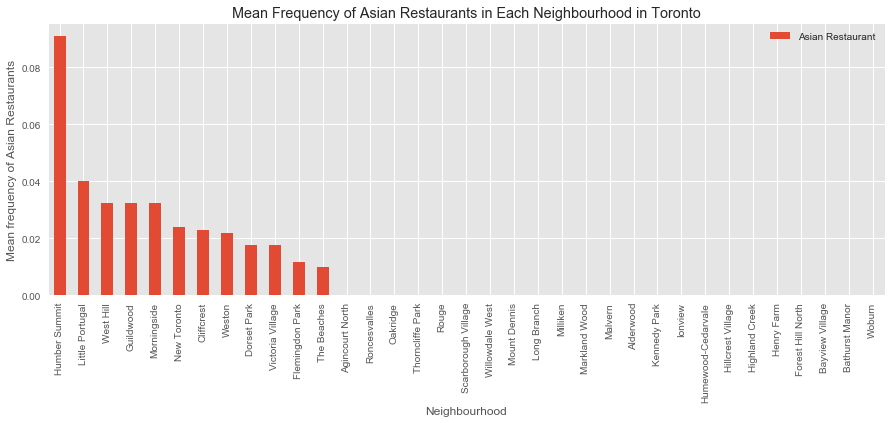

In [85]:
# sort by descending order
toronto_grouped.sort_values(by='Asian Restaurant', ascending=False, inplace=True)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot')
toronto_grouped.plot(kind='bar', figsize=(15,5))

plt.title('Mean Frequency of Asian Restaurants in Each Neighbourhood in Toronto')
plt.xlabel('Neighbourhood')
plt.ylabel('Mean frequency of Asian Restaurants')

plt.show()

As inferred from the bar chart, Humber Summit is most densely populated with Asian Restaurants; hence, it is not advisable for business operations to be taken place here.

### Plotting a bar graph to illustrate the distribution of Southeast Asian population group in each neighbourhood

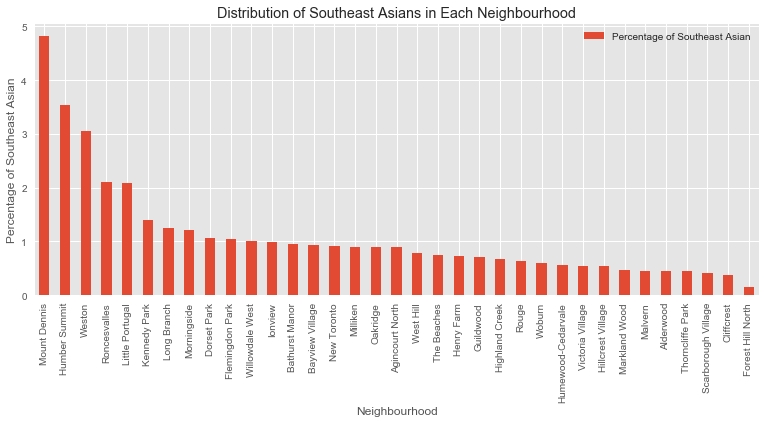

In [86]:
df_ethnic = df[['Neighbourhood', 'Percentage of Southeast Asian']].set_index('Neighbourhood')

# sort by descending order
df_ethnic.sort_values(by='Percentage of Southeast Asian', ascending=False, inplace=True)

#plot bar graph
df_ethnic.plot(kind='bar', figsize=(13,5))
plt.title('Distribution of Southeast Asians in Each Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Percentage of Southeast Asian')

plt.show()

As inferred from above, Mount Dennis is the neighbourhood most densely populated with Southeast Asians.

### Plotting a bar graph to illustrate the distribution of income groups in each neighbourhood

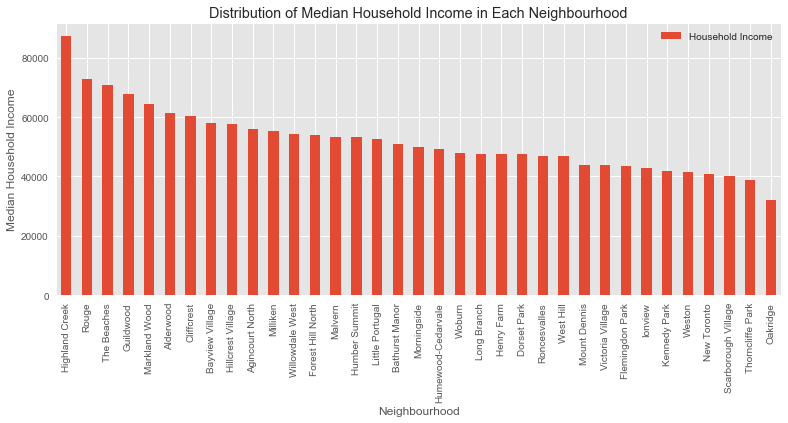

In [87]:
df_income = df[['Neighbourhood', 'Household Income']].set_index('Neighbourhood')

# sort by descending order
df_income.sort_values(by='Household Income', ascending=False, inplace=True)

#plot bar graph
df_income.plot(kind='bar', figsize=(13,5))
plt.title('Distribution of Median Household Income in Each Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Median Household Income')

plt.show()

### Finalise a dataframe for clustering

In [88]:
# merge df with toronto_grouped
df_final = pd.merge(df, toronto_grouped, on='Neighbourhood')

In [89]:
df_final.head()

,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Southeast Asian,Asian Restaurant
0,Victoria Village,43.725882,-79.315572,43743.0,0.542547,0.017544
1,Rouge,43.806686,-79.194353,72784.0,0.634463,0.000000
2,Malvern,43.806686,-79.194353,53425.0,0.456684,0.000000
3,Highland Creek,43.784535,-79.160497,87321.0,0.680327,0.000000
4,Flemingdon Park,43.725900,-79.340923,43511.0,1.048648,0.011628


## Cluster Neighbourhoods

#### Normalizing over the standard deviation
Now let's normalize the dataset. But why do we need normalization in the first place? Normalization is a statistical method that helps mathematical-based algorithms to interpret features with different magnitudes and distributions equally. We use __StandardScaler()__ to normalize our dataset.

In [90]:
from sklearn.preprocessing import StandardScaler
X = df_final.values[:,3:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

array([[-7.63184014e-01, -5.81950853e-01,  4.06015324e-01],
       [ 1.89181483e+00, -4.85200866e-01, -5.47869802e-01],
       [ 1.21967973e-01, -6.72330023e-01, -5.47869802e-01],
       [ 3.22082273e+00, -4.36925505e-01, -5.47869802e-01],
       [-7.84394018e-01, -4.92336428e-02,  8.43563860e-02],
       [-2.59537836e-01, -5.66833506e-01, -5.47869802e-01],
       [ 1.11591265e+00, -6.54361814e-01, -5.47869802e-01],
       [ 1.42501190e+00, -4.10050688e-01,  1.20604801e+00],
       [-1.84845709e-01,  1.13334257e-01,  1.20604801e+00],
       [-4.83431372e-01, -3.26851741e-01,  1.20604801e+00],
       [ 1.72478605e+00, -3.72141075e-01, -4.15528029e-03],
       [-3.82409585e-01, -5.33107430e-01, -5.47869802e-01],
       [ 5.11153266e-01, -5.93605112e-01, -5.47869802e-01],
       [-9.27833202e-02, -1.58331725e-01, -5.47869802e-01],
       [-1.22925557e+00, -6.79295266e-01, -5.47869802e-01],
       [-1.08883072e+00, -7.12458368e-01, -5.47869802e-01],
       [-4.05173770e-01, -3.83152836e-01

In [91]:
df_normalized = pd.DataFrame(Clus_dataSet)
df_normalized.rename(columns={0:'Household Income', 1:'% Southeast Asian', 2:'No. of Asian Restaurants'}, inplace=True)
df_normalized.head()

,Household Income,% Southeast Asian,No. of Asian Restaurants
0,-0.763184,-0.581951,0.406015
1,1.891815,-0.485201,-0.547870
2,0.121968,-0.672330,-0.547870
3,3.220823,-0.436926,-0.547870
4,-0.784394,-0.049234,0.084356


### Finding the optimal number of clusters, k
So, how can we choose right value for K? The general solution is to reserve a part of your data for testing the accuracy of the model. Then chose k =1, use the training part for modeling, and calculate the accuracy of prediction using all samples in your test set. Repeat this process, increasing the k, and see which k is the best for your model.



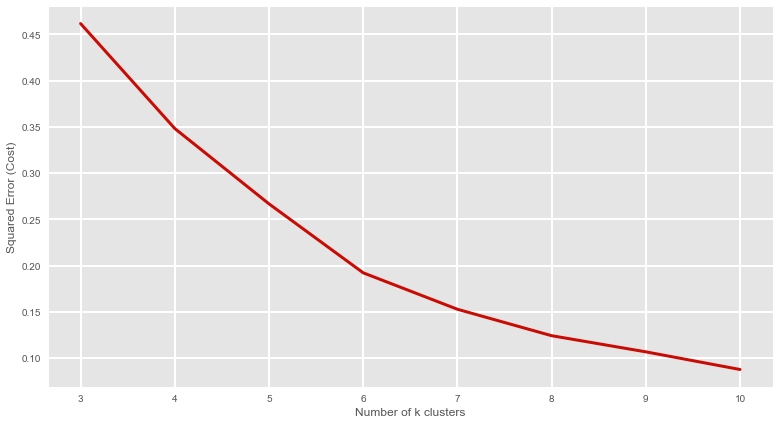

In [92]:
from sklearn.cluster import KMeans

error_cost=[]

for i in range(3, 11):
    KM = KMeans(n_clusters=i, max_iter=100)
    try:
        KM.fit(df_normalized)

    except ValueError:
        print('Error on line', i)

  # calculate squared error for the clustered points
    error_cost.append(KM.inertia_ / 100)

# plot the K values against the squared error cost
plt.figure(figsize=(13,7))
plt.plot(range(3,11), error_cost, color='r', linewidth=3)
plt.xlabel('Number of k clusters')
plt.ylabel('Squared Error (Cost)')
plt.grid(color='white', linestyle='-', linewidth=2)

plt.show()

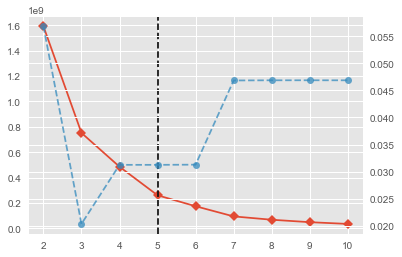

In [93]:
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
for k in range(1):
    model = KMeans(n_clusters=(3,11))
    visualizer = KElbowVisualizer(model)

    visualizer.fit(X)
    visualizer

After analysing using elbow method using distortion score & Squared error for each K value, looks like K = 6 is the best value.

## Clustering the Toronto Neighborhood Using K-Means with K = 6

In [94]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_normalized)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 3, 2, 3, 0, 2, 3, 3, 0, 0])

Create a new dataframe that includes the cluster

In [95]:
df_normalized.drop(['Household Income', '% Southeast Asian'], axis=1, inplace=True)
df_clustered = pd.merge(df, df_normalized, left_index=True, right_index=True)
df_clustered.insert(0, 'Cluster Label', kmeans.labels_)

### Visulize the clusters on a map

In [96]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude,longitude], zoom_start=11)

# set color schemes for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_clustered['Latitude'], df_clustered['Longitude'], df_clustered['Neighbourhood'], df_clustered['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine clusters

### Cluster 0

In [97]:
df_clustered.loc[df_clustered['Cluster Label'] == 0]

,Cluster Label,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Southeast Asian,No. of Asian Restaurants
0,0,Victoria Village,43.725882,-79.315572,43743.0,0.542547,0.406015
4,0,Flemingdon Park,43.725900,-79.340923,43511.0,1.048648,0.084356
8,0,Morningside,43.763573,-79.188711,50069.0,1.203094,1.206048
9,0,West Hill,43.763573,-79.188711,46803.0,0.784901,1.206048
17,0,Little Portugal,43.647927,-79.419750,52519.0,2.088823,1.626988
26,0,Dorset Park,43.757410,-79.273304,47630.0,1.059873,0.406015
32,0,New Toronto,43.605647,-79.501321,40859.0,0.915991,0.746689


### Cluster 1

In [98]:
df_clustered.loc[df_clustered['Cluster Label'] == 1]

,Cluster Label,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Southeast Asian,No. of Asian Restaurants
22,1,Humber Summit,43.756303,-79.565963,53272.0,3.543814,4.394989


### Cluster 2

In [99]:
df_clustered.loc[df_clustered['Cluster Label'] == 2]

,Cluster Label,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Southeast Asian,No. of Asian Restaurants
2,2,Malvern,43.806686,-79.194353,53425.0,0.456684,-0.54787
5,2,Humewood-Cedarvale,43.693781,-79.428191,49252.0,0.556909,-0.54787
11,2,Woburn,43.770992,-79.216917,47908.0,0.588950,-0.54787
12,2,Hillcrest Village,43.803762,-79.363452,57682.0,0.531475,-0.54787
13,2,Bathurst Manor,43.754328,-79.442259,51076.0,0.945001,-0.54787
14,2,Thorncliffe Park,43.705369,-79.349372,38645.0,0.450066,-0.54787
15,2,Scarborough Village,43.744734,-79.239476,40181.0,0.418560,-0.54787
16,2,Henry Farm,43.778517,-79.346556,47659.0,0.731413,-0.54787
18,2,Ionview,43.727929,-79.262029,42971.0,0.989664,-0.54787
19,2,Kennedy Park,43.727929,-79.262029,41776.0,1.401624,-0.54787


### Cluster 3

In [100]:
df_clustered.loc[df_clustered['Cluster Label'] == 3]

,Cluster Label,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Southeast Asian,No. of Asian Restaurants
1,3,Rouge,43.806686,-79.194353,72784.0,0.634463,-0.547870
3,3,Highland Creek,43.784535,-79.160497,87321.0,0.680327,-0.547870
6,3,Markland Wood,43.643515,-79.577201,64297.0,0.473754,-0.547870
7,3,Guildwood,43.763573,-79.188711,67678.0,0.705859,1.206048
10,3,The Beaches,43.676357,-79.293031,70957.0,0.741874,-0.004155
23,3,Cliffcrest,43.716316,-79.239476,60384.0,0.376530,0.687845
33,3,Alderwood,43.602414,-79.543484,61402.0,0.456280,-0.547870


### Cluster 4

In [101]:
df_clustered.loc[df_clustered['Cluster Label'] == 4]

,Cluster Label,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Southeast Asian,No. of Asian Restaurants
24,4,Mount Dennis,43.691116,-79.476013,43790.0,4.818657,-0.547870
25,4,Weston,43.706876,-79.518188,41356.0,3.056914,0.634118


## Cluster 0:

* MID Spending Power
* MID Percentage of Target Customers
* MID Number of Competitors

## Cluster 1:

* MID Spending Power
* HIGH Percentage of Target Customers
* HIGH Number of Competitors

## Cluster 2:

* LOW Spending Power
* MID Percentage of Target Customers
* LOW Number of Competitors

## Cluster 3:

* HIGH Spending Power
* MID Percentage of Target Customers
* LOW Number of Competitors

## Cluster 4:

* LOW Spending Power
* MID Percentage of Target Customers
* MID Number of Competitors

# Conclusion

In this study, I have labeled the neighbourhoods corresponding to their characteristics — spending power, percentage of target customers, and the number of competitors. The most promising group of neighbourhoods for opening an Asian Restaurant, with a niche in Southeast Asian cuisine, appears to be ***'Cluster Label 3'***.

The higher spending power of the neighbourhoods in this cluster allows them to readily afford the slightly upscaled prices of the client’s Asian restaurant menu.

The average distribution of the percentage of target customers — the Southeast Asian demographic — indicates a relatively reasonable demand for the Asian cuisine.

The number of competitors is also less.

# The END!!